# Metricas, Generación y Pre-Post Pipeline para TDZDD

Por: Carlos Olguin - MSC

Leyendo: resultados_test/memoria_log.csv


C:\Users\carlo\AppData\Local\Temp\ipykernel_16680\1594548996.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


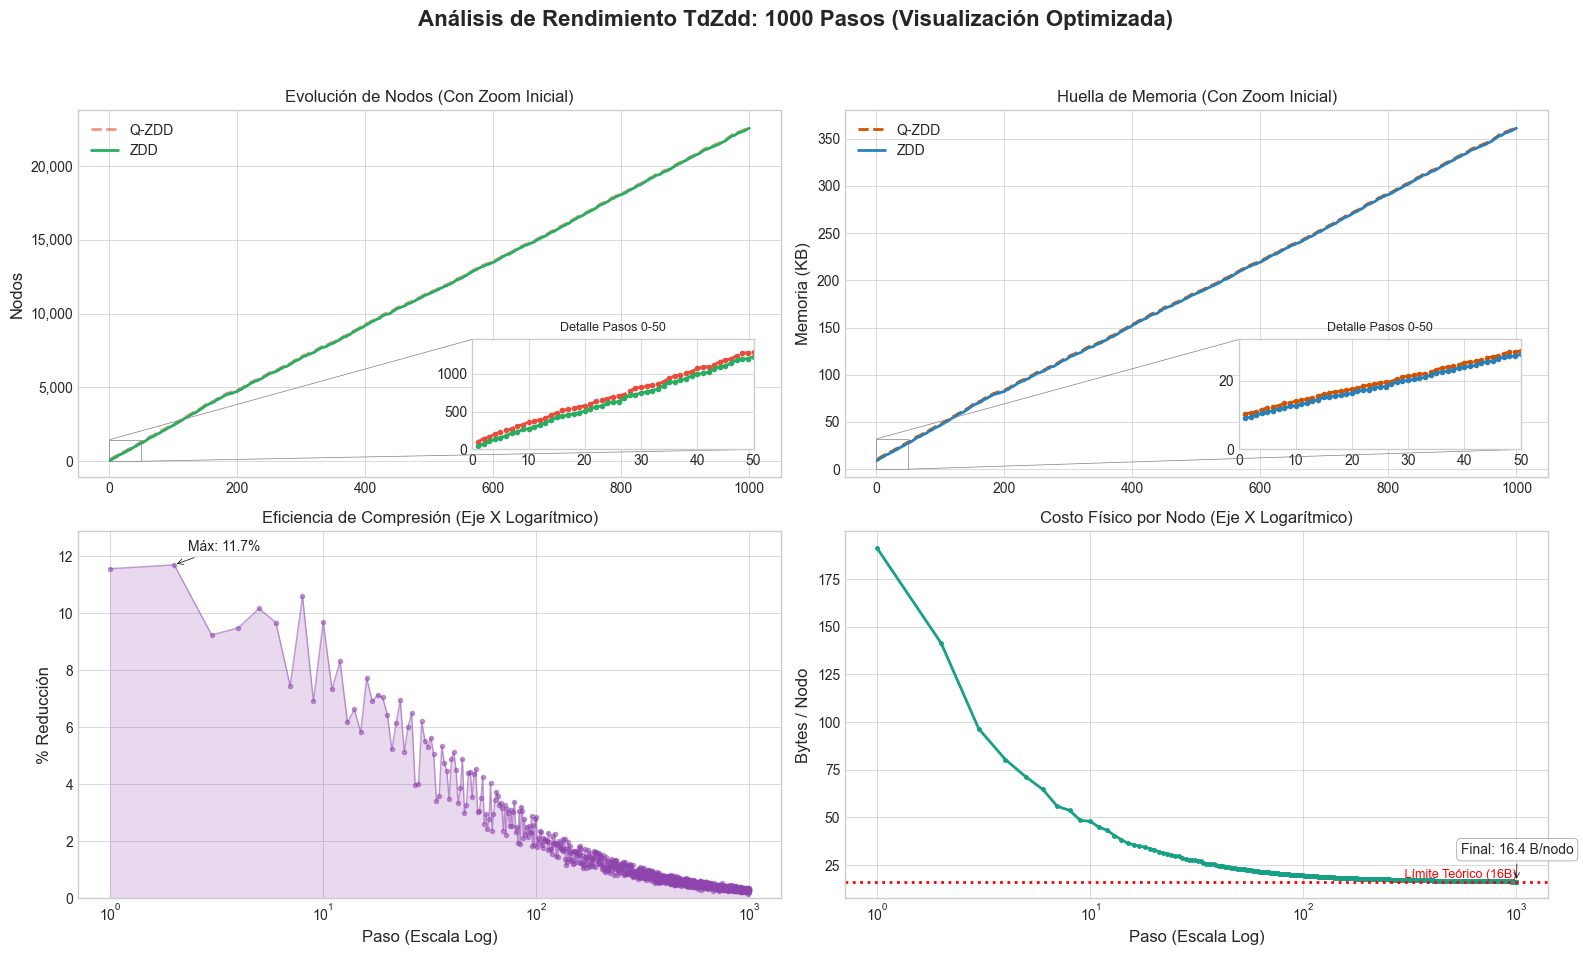

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import os

# --- Configuración ---
OUTPUT_DIR = "resultados_test/"
CSV_FILE = "memoria_log.csv"
CSV_PATH = os.path.join(OUTPUT_DIR, CSV_FILE)

if not os.path.exists(CSV_PATH):
    print(f"Error: No se encontró {CSV_PATH}")
    exit()

print(f"Leyendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Cálculos
df['Reduccion_Pct'] = ((df['Bytes_QZDD'] - df['Bytes_ZDD']) / df['Bytes_QZDD']) * 100
df['Bytes_Por_Nodo'] = df['Bytes_ZDD'] / df['Nodos_ZDD']

# Estilo
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')

# Colores
C_QZDD = '#e74c3c'
C_ZDD  = '#27ae60'
C_MEM_Q = '#d35400'
C_MEM_Z = '#2980b9'
C_EFF   = '#8e44ad'
C_DENS  = '#16a085'

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Análisis de Rendimiento TdZdd: {len(df)} Pasos (Visualización Optimizada)', fontsize=16, fontweight='bold')
fmt_miles = ticker.StrMethodFormatter('{x:,.0f}')

# =============================================================================
# 1. EVOLUCIÓN ESTRUCTURAL (Con ZOOM INSET)
# =============================================================================
ax1 = axs[0, 0]
ax1.plot(df['Paso'], df['Nodos_QZDD'], label='Q-ZDD', color=C_QZDD, linestyle='--', alpha=0.6)
ax1.plot(df['Paso'], df['Nodos_ZDD'], label='ZDD', color=C_ZDD, linewidth=2)
ax1.fill_between(df['Paso'], df['Nodos_QZDD'], df['Nodos_ZDD'], color=C_QZDD, alpha=0.1)

ax1.set_title('Evolución de Nodos (Con Zoom Inicial)', fontsize=12)
ax1.set_ylabel('Nodos')
ax1.legend(loc='upper left')
ax1.yaxis.set_major_formatter(fmt_miles)

# --- CREAR EL ZOOM (INSET) ---
# Creamos un eje hijo dentro del eje padre
axins1 = inset_axes(ax1, width="40%", height="30%", loc='lower right', borderpad=2)
axins1.plot(df['Paso'], df['Nodos_QZDD'], color=C_QZDD, linestyle='--', marker='.')
axins1.plot(df['Paso'], df['Nodos_ZDD'], color=C_ZDD, marker='.')
axins1.fill_between(df['Paso'], df['Nodos_QZDD'], df['Nodos_ZDD'], color=C_QZDD, alpha=0.1)

# Configuramos el Zoom a los primeros 50 pasos
axins1.set_xlim(0, 50) 
axins1.set_ylim(0, df['Nodos_QZDD'].iloc[50] * 1.1) 
axins1.grid(True)
axins1.set_title("Detalle Pasos 0-50", fontsize=9)
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5") # Líneas conectoras

# =============================================================================
# 2. CONSUMO MEMORIA (Con ZOOM INSET)
# =============================================================================
ax2 = axs[0, 1]
ax2.plot(df['Paso'], df['KB_QZDD'], label='Q-ZDD', color=C_MEM_Q, linestyle='--')
ax2.plot(df['Paso'], df['KB_ZDD'], label='ZDD', color=C_MEM_Z, linewidth=2)

ax2.set_title('Huella de Memoria (Con Zoom Inicial)', fontsize=12)
ax2.set_ylabel('Memoria (KB)')
ax2.legend(loc='upper left')
ax2.yaxis.set_major_formatter(fmt_miles)

# --- CREAR EL ZOOM (INSET) ---
axins2 = inset_axes(ax2, width="40%", height="30%", loc='lower right', borderpad=2)
axins2.plot(df['Paso'], df['KB_QZDD'], color=C_MEM_Q, linestyle='--', marker='.')
axins2.plot(df['Paso'], df['KB_ZDD'], color=C_MEM_Z, marker='.')

# Zoom a los primeros 50 pasos
axins2.set_xlim(0, 50)
ymax_zoom = df['KB_QZDD'].iloc[50] * 1.1
axins2.set_ylim(0, ymax_zoom)
axins2.grid(True)
axins2.set_title("Detalle Pasos 0-50", fontsize=9)
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")

# =============================================================================
# 3. EFICIENCIA (EJE X LOGARÍTMICO)
# =============================================================================
ax3 = axs[1, 0]
# Usamos semilogx para expandir el inicio
ax3.semilogx(df['Paso'], df['Reduccion_Pct'], color=C_EFF, linewidth=1, marker='o', markersize=3, alpha=0.5)
ax3.fill_between(df['Paso'], df['Reduccion_Pct'], color=C_EFF, alpha=0.2)

ax3.set_title('Eficiencia de Compresión (Eje X Logarítmico)', fontsize=12)
ax3.set_ylabel('% Reducción')
ax3.set_xlabel('Paso (Escala Log)')
ax3.set_ylim(0, max(df['Reduccion_Pct']) * 1.1)

# Anotación del pico
max_eff = df['Reduccion_Pct'].max()
max_eff_idx = df['Reduccion_Pct'].idxmax()
ax3.annotate(f'Máx: {max_eff:.1f}%', 
             xy=(df['Paso'][max_eff_idx], max_eff), 
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# =============================================================================
# 4. DENSIDAD (EJE X LOGARÍTMICO)
# =============================================================================
ax4 = axs[1, 1]
ax4.semilogx(df['Paso'], df['Bytes_Por_Nodo'], color=C_DENS, linewidth=2, marker='.', markersize=5)

ax4.axhline(y=16, color='r', linestyle=':', label='Payload (16B)')
ax4.text(df['Paso'].iloc[-1], 16.5, ' Límite Teórico (16B)', color='r', va='bottom', ha='right', fontsize=9)

ax4.set_title('Costo Físico por Nodo (Eje X Logarítmico)', fontsize=12)
ax4.set_ylabel('Bytes / Nodo')
ax4.set_xlabel('Paso (Escala Log)')

# Anotación del valor final (asíntota)
val_final = df['Bytes_Por_Nodo'].iloc[-1]
ax4.annotate(f'Final: {val_final:.1f} B/nodo', 
             xy=(df['Paso'].iloc[-1], val_final), 
             xytext=(-40, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'),
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Recordar la compresión es dependiente del dataset, los ZDD funcionan bien para conjuntos mas sparse (dispersos), es decir, hay que tener en cuenta el universo y los elementos en el total de estos!